In [1]:
import numpy as np
import pandas as pd 
import pyro
import torch 
import pyro.distributions as dist 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from pyro import optim
from pyro.infer import SVI, Trace_ELBO
from npsde_pyro import NPSDE, Kernel



In [2]:
def model(npsde, start, end, n_segments=5):
    start_t, start_point = start[0], start[1:] 
    end_t, end_point = end[0], end[1:]
    n_dims = end.shape[0] - 1
    delta_t = (end_t - start_t) / n_segments
    linear_interpolation = np.array([np.linspace(start_point[i], end_point[i], n_segments+1) for i in range(n_dims)]).T 

    nodes = pyro.sample('nodes', dist.Normal(torch.tensor(linear_interpolation, dtype=torch.float32), torch.ones(linear_interpolation.shape)).to_event(1).to_event(1))

    fs, gs = npsde.fgAt(nodes[:-1, :])
    for i in range(n_segments):
        drift = fs[i,:]
        diffusion = gs[i,:]
        # Assume on-diagonal 
        covariance = torch.diag(diffusion)

        # Brownian bridge test
        # t1 = delta_t * (i + 1)
        # t2 = delta_t * (n_segments - i - 1)
        # BB_mean = (start_point * t2 + end_point * t1) / (t1 + t2)
        # BB_variance = t1 * t2 / (t1 + t2) + 0.0001
        # pyro.sample('node_{}'.format(i+1), dist.MultivariateNormal(torch.tensor(BB_mean,dtype=torch.float32), torch.diag(torch.tensor([BB_variance] * n_dims, dtype=torch.float32))), obs=nodes[i+1])

        pyro.sample('node_{}'.format(i+1), dist.MultivariateNormal(drift * delta_t, covariance * delta_t), obs=nodes[i+1])


def guide(npsde, start, end, n_segments=5):
    start_t, start_point = start[0], start[1:] 
    end_t, end_point = end[0], end[1:]
    n_dims = end.shape[0] - 1
    delta_t = (end_t - start_t) / n_segments
    linear_interpolation = np.array([np.linspace(start_point[i], end_point[i], n_segments+1) for i in range(n_dims)]).T 
    # todo: fix to known start and end 
    nodes_q_init =  torch.tensor(linear_interpolation[1:-1,:], dtype=torch.float32) # +torch.randn(n_segments-1, n_dims)*.75
    nodes_q = pyro.param("nodes_q", nodes_q_init)
    nodes = pyro.sample('nodes', dist.Delta(torch.cat(
        (torch.tensor(np.atleast_2d(linear_interpolation[0,:]), dtype=torch.float32), 
        nodes_q, 
        torch.tensor(np.atleast_2d(linear_interpolation[-1,:]), dtype=torch.float32)))).to_event(1).to_event(1))


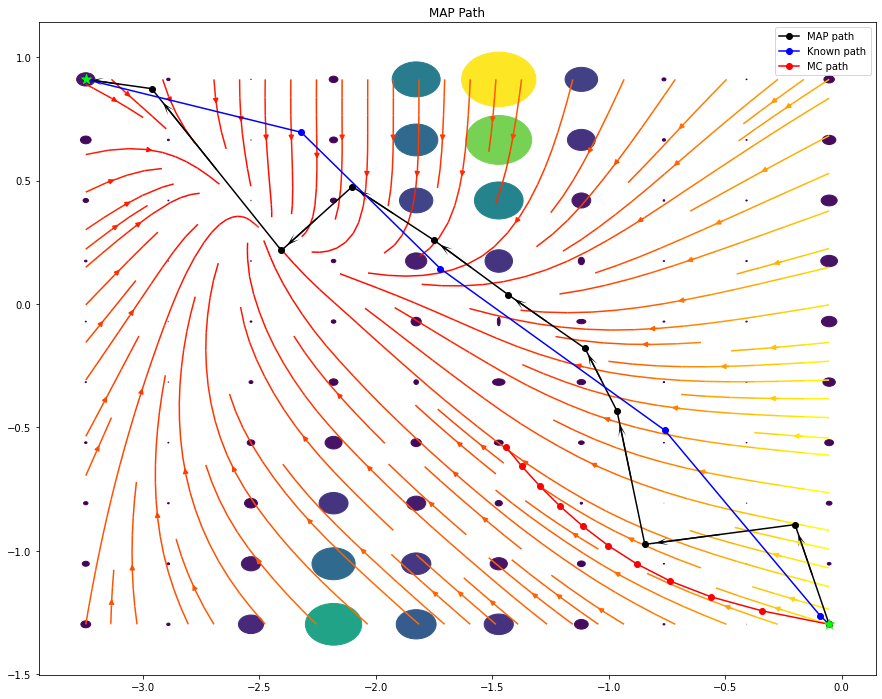

In [6]:

def plot(self,  start_, end_, margin=0.2, comparison=None, fname=None):

    with torch.no_grad():
        Z = self.Z.detach() 
        Zg = self.Zg.detach() 
        U = pyro.get_param_store().get_param('U_map').detach() 
        Ug = pyro.get_param_store().get_param('Ug_map').detach() 
        sf_f = self.sf_f if self.fix_sf else pyro.param('sf_f', self.sf_f).detach() 
        sf_g = self.sf_g if self.fix_sf else pyro.param('sf_g', self.sf_g).detach() 
        ell_f = self.ell_f if self.fix_ell else pyro.param('ell_f', self.ell_f).detach() 
        ell_g = self.ell_g if self.fix_ell else pyro.param('ell_g', self.ell_g).detach() 
        kernel_f = Kernel(sf_f, ell_f)
        kernel_g = Kernel(sf_g, ell_g)

    start = start_[1:]
    end = end_[1:]
    dist = end - start 
    nodes = np.concatenate((np.atleast_2d(start), pyro.param("nodes_q").detach().numpy(), np.atleast_2d(end))) 
    


    extents = [min(nodes[:,0].tolist() + [start[0], end[0]]) , max(nodes[:,0].tolist() + [start[0], end[0]]) ,
    min(nodes[:,1].tolist()+ [start[1], end[1]]) , max(nodes[:,1].tolist()+[start[1], end[1]])]
    
    
    W = 10
    # Fixed boundaries
    xv = np.linspace(extents[0], extents[1], W)
    yv = np.linspace(extents[2], extents[3], W)
    xvv,yvv = np.meshgrid(xv,yv, indexing='ij')


    Zs = np.array([xvv.T.flatten(),yvv.T.flatten()], dtype=np.float32).T

    U = self.unwhiten_U(U, Z, kernel_f)
    Ug = self.unwhiten_U(Ug, Zg, kernel_g)

    f,g = self.calc_drift_diffusion(Zs, U, Ug, Z, Zg, kernel_f, kernel_g)

    Us = f.detach().numpy()
    Ugs = g.detach().numpy()

    fig = plt.figure(2, figsize=(15,12))
    gs = mpl.gridspec.GridSpec(nrows=10, ncols=10)
    ax1 = plt.subplot(gs[0:10,0:10])
    # ax2 = plt.subplot(gs[0:10,11])
    # ax3 = plt.subplot(gs[11,0:10])
    Uc = np.sqrt(Us[:,0] ** 2 + Us[:,1] ** 2)
    strm = ax1.streamplot(np.unique(list(Zs[:,0])), np.unique(list(Zs[:,1])), Us[:,0].reshape(W,W), Us[:,1].reshape(W,W), color=Uc.reshape(W,W), cmap='autumn')
    ax1.set_title('MAP Path')


    Ugs = Ugs.reshape(W, W, 2) 
    mag = (Ugs[:,:,0] ** 2 + Ugs[:,:,1] ** 2) ** 0.5
    x_max, y_max, mag_max, mag_min = Ugs[:,:,0].max(), Ugs[:,:,1].max() , mag.max(), mag.min()
    x_delta, y_delta = (extents[1] - extents[0]) / W, (extents[3] - extents[2]) / W

    Zs_grid = Zs.reshape(W, W, 2)
    ellipses = [] 
    cmap = mpl.cm.get_cmap('viridis')
    for r in range(W):
        for c in range(W):
            ellipses += [ax1.add_patch(mpl.patches.Ellipse(Zs_grid[r, c], np.sqrt(Ugs[r,c,0]/x_max)*(x_delta), np.sqrt(Ugs[r,c,1]/y_max)*(y_delta), color=cmap(((Ugs[r,c,0] ** 2 + Ugs[r,c,1] ** 2) ** 0.5 - mag_min) / (mag_max - mag_min))))]


    midpoints = np.add(nodes[:-1,:], nodes[1:,:]) /2 
    directions = (nodes[1:,:] - nodes[:-1,:]) 
    directions /= np.linalg.norm(directions)
    ax1.plot(nodes[:,0], nodes[:,1], '-ko', label='MAP path')
    if comparison is not None:
        ax1.plot(comparison[:,0], comparison[:,1], '-bo', label='Known path')
        delta_t = (end_[0] - start_[0]) / (len(nodes)-1)
        forward = np.mean(self.forward(nodes[0,:],np.float32(delta_t), len(nodes)-1, 50),axis=0)
        ax1.plot(forward[:,0], forward[:,1], '-ro', label='MC path')

        ax1.plot()
    ax1.quiver(midpoints[:,0], midpoints[:,1], directions[:,0], directions[:,1], angles='xy', units='height',width=0.002, headwidth=6, headlength=10)
    ax1.scatter([start[0], end[0]], [start[1], end[1]], marker='*', c='#00ff00', s=100, zorder=3)

    ax1.legend()
    # mpl.colorbar.ColorbarBase(ax3, cmap = cmap, norm = mpl.colors.Normalize(vmin=mag_min, vmax=mag_max), orientation='horizontal')
    # mpl.colorbar.ColorbarBase(ax2, cmap = mpl.cm.get_cmap('autumn'), norm = mpl.colors.Normalize(vmin=Uc.min(), vmax=Uc.max()), orientation='vertical')

    if fname is None:
        plt.show() 
    else:
        plt.savefig(fname, dpi=400)

# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = optim.Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 1000

npsde_model = NPSDE.load_model('model1.pt') 

df = pd.read_csv('data/seshat/Seshat_old_pca.csv')
components =['PCA0','PCA1']
df['time'] = df[['NGA','Time']].groupby('NGA').transform(lambda x: (x - x.min()) / 100. )['Time']
df = df[['time'] + components].to_numpy(dtype=np.float32)

# do gradient steps
loss_graph = [] 
window = []
window_size = 10
start = df[158,:3]
end = df[163,:3]
for step in range(n_steps):
    loss = svi.step(npsde_model, start, end, n_segments=10)
    window += [loss]
    if len(window) >= window_size:
        loss_graph += [np.mean(window)]
        window = [] 


plot(npsde_model, start, end, comparison=df[158:164,1:3], fname='Latium.png')

# Brownian bridge test
# nodes = np.concatenate((np.atleast_2d(start[1:]), pyro.param("nodes_q").detach().numpy(), np.atleast_2d(end[1:]))) 
# plt.plot(nodes[:,0], nodes[:,1], '-ko', label='MAP path')
# plt.savefig('BrownianBridge6.png', dpi=400)

# plt.figure()
# plt.plot(np.arange(0, n_steps, window_size), loss_graph)
# plt.title('Objective Loss (smooth=%d)' % window_size)
# plt.savefig('objective_loss.png')